In [ ]:
# Installing pytorch lightning
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
# Installing dependencies

import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [ ]:
# Creating images path

data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)


In [ ]:
#Installing kaggle to get the dataset
!pip install -q kaggle


In [ ]:
#Creating a kaggle dir in the root
!mkdir ~/.kaggle


In [ ]:
#Copying API key to kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
# Give the permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# Download the data
!kaggle datasets download 'tolgadincer/labeled-chest-xray-images'


 99% 1.16G/1.17G [00:09<00:00, 134MB/s]
100% 1.17G/1.17G [00:09<00:00, 128MB/s]


In [ ]:
#Unzip the data
!unzip labeled-chest-xray-images.zip


In [ ]:
%cd /content/chest_xray/train/


/content/chest_xray/train


In [1]:
# Make 2 new directories
!mkdir BACTERIA && mkdir VIRUS


In [ ]:
# Read the PNEUMONIA dataset and use photo names to crete 2 more dirs with photos
import os
import shutil

pneumonia = os.listdir('/content/chest_xray/train/PNEUMONIA')
pneumonia.sort()

for i in range(len(pneumonia)):
  if "BACTERIA" in pneumonia[i]:
    # absolute path
    src_path = f"/content/chest_xray/train/PNEUMONIA/{pneumonia[i]}"
    dst_path = f"/content/chest_xray/train/BACTERIA/{pneumonia[i]}"
    shutil.copy(src_path, dst_path)
  else:
    src_path = f"/content/chest_xray/train/PNEUMONIA/{pneumonia[i]}"
    dst_path = f"/content/chest_xray/train/VIRUS/{pneumonia[i]}"
    shutil.copy(src_path, dst_path)

In [ ]:
#Remove PNEUMONIA
!rm -rf /content/chest_xray/train/PNEUMONIA/

In [ ]:
# Create train and val data 85% percent to 15%
data_dir = Path('/content/chest_xray/train/')
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])


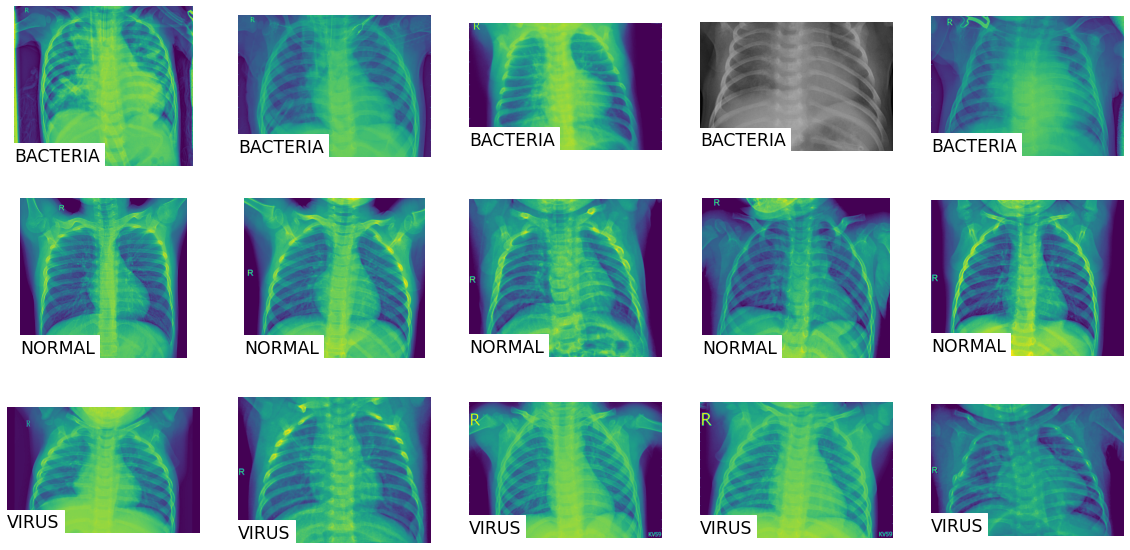

In [ ]:
# Visualize some images
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [ ]:
# label2id and id2label is needed is lightning, we use our classes

label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [ ]:
# Image classification collator is a class that is being used in DataLoader we use our feature extractor from huggingface again
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [ ]:
# Feature extractor being initiated, model loaded, collator initated and dataloaders are finally initiated.
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Classifier from lightning is defined below, we need our model, learning rate, training and validation data to be passed here.

class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# To get reproducable results we define a seed, we initiate our classifier, we create and fit (train) our trained using lightning trainer.
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=4)
trainer.fit(classifier, train_loader, val_loader)

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:245: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/chest_xray/train/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# Here can be checked the results of the training comparing the predictions and true labels on a set of images
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
# print(val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([2, 0, 0, 0, 2, 0, 2, 1])
Labels: tensor([2, 0, 2, 0, 2, 0, 2, 1])
